#### Домашнее задание

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

2. *Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

### Задание1
В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

Точки останова:
1. Если все обекты принадлежат одному классу, исправления в **_find_best_split_**
2. Если прирост качества при разбиении меньше определённого порогового процента, исправления в **_find_best_split_**
3. Точка останова по глубине дерева, исправления в **build_tree**
4. Точка останова по максимальному количесву листьев, исправления в **build_tree**

основные изменения в коде выделены блоками <br>
\# ------------------------------------------------------ <br>
\# -------------------------------------------------------


In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)


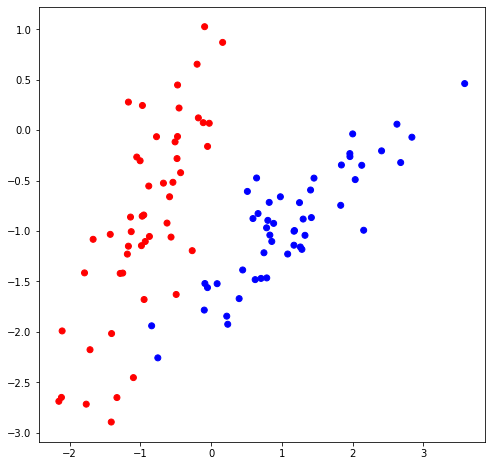

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #----------------------------------------------------------------------------------------------------------------
    #  Если все обекты принадлежат одному классу, не производим разбиения и формируем лист
    if len(np.unique(labels))==1:
        return 0, 0, 0   
    
    #----------------------------------------------------------------------------------------------------------------

    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 1

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index
    
    #----------------------------------------------------------------------------------------------------------------
    # Если прирост качества при разбиении меньше определённого процента, рабиение не производим и создаём лист 
    coef_min_gain = 0.01   
    if (coef_min_gain*root_gini > best_gain):
        return 0, 0, 0         
    
    #----------------------------------------------------------------------------------------------------------------    
    
    return best_gain, best_t, best_index

In [10]:
import time
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, depth=1, sheet=0):
        
    # ----------------------------------------------------------------------------------------------------------------
    # Точка останова по глубине дерева
    max_depth = 3
    if (max_depth < depth):
        sheet +=1
        return Leaf(data, labels), sheet      
    depth +=1
    # ----------------------------------------------------------------------------------------------------------------   
    
    
    gain, t, index = find_best_split(data, labels)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        sheet +=1
        return Leaf(data, labels), sheet 
    
    
    #----------------------------------------------------------------------------------------------------------------
    # Точка останова по максимальному количесву листьев   
    max_sheet = 3   # задаём максимальное количество листьев
    sheet +=1       # резервируем в счётчике место для одного листа на ветке false_branch. Это на случай если максимальное 
                    # число литьев достигнуто, а дерево еще построено не полностью.  
    if max_sheet == sheet:
        return Leaf(data, labels), sheet 
    #----------------------------------------------------------------------------------------------------------------         
    
    
    
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch, sheet  = build_tree(true_data, true_labels, depth, sheet)

#     print(time.time(), true_branch)

    #----------------------------------------------------------------------------------------------------------------
    # Снимаем со счётчика резер. 
    sheet -=1    
    #----------------------------------------------------------------------------------------------------------------
    
    false_branch, sheet  = build_tree(false_data, false_labels, depth, sheet)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch), sheet 

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [14]:
# Построим дерево по обучающей выборке
my_tree, sheet = build_tree(train_data, train_labels)

In [15]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
#     plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
#     plt.title(f'Test accuracy={test_accuracy:.2f}')

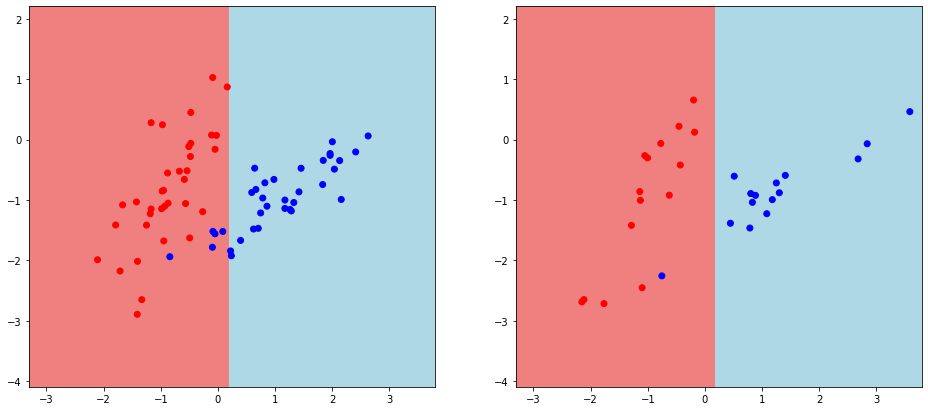

In [16]:
visualize(train_data, test_data)

In [17]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0 <= 0.16261402870113306
--> True:
  Индекс 1 <= -1.5208896621663803
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


В примере заданы точки останова:<br>
    coef_min_gain = 0.01<br>
    max_depth = 3<br>
    max_sheet = 3<br>
Сработало ограничение по количеству листьев = 3

### Задание2
*Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [18]:
from sklearn import datasets
from sklearn.metrics import r2_score
import seaborn as sns

In [19]:
X_train, y_train, coef = datasets.make_regression(n_samples=10000, n_features=3, n_informative=3, n_targets=1, 
                                      noise=5, coef=True, random_state=42)
print(coef)

[43.32504238 88.16437552 83.18686148]


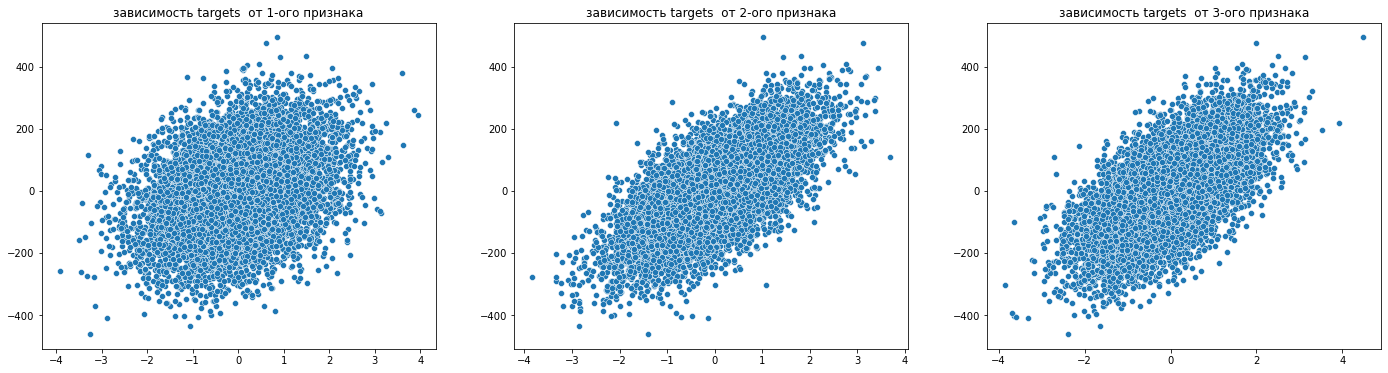

In [20]:
# визуализируем сгенерированные данные

plt.figure(figsize=(24,6))

plt.subplot(1,3,1)
plt.title('зависимость targets  от 1-ого признака')
sns.scatterplot(X_train[:,0], y_train)
plt. subplot(1,3,2)
plt.title('зависимость targets  от 2-ого признака')
sns.scatterplot(X_train[:,1], y_train)
plt. subplot(1,3,3)
plt.title('зависимость targets  от 3-ого признака')
sns.scatterplot(X_train[:,2], y_train)
plt.show()

In [21]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [22]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        prediction = np.mean(self.labels)
        return prediction  

In [23]:
# Расчет MSE

def mse(labels):
    mse = np.mean((labels-np.mean(labels))**2)
    return mse


In [24]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * mse(left_labels) - (1 - p) * mse(right_labels)

In [25]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [26]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_gini = mse(labels)
    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index
    
    #----------------------------------------------------------------------------------------------------------------
    # Если прирост качества при разбиении меньше определённого процента рабиение не производим и создаём лист 
    coef_min_gain = 0.01    # зададим 1% 
    if (coef_min_gain*root_gini > best_gain):
        return 0, 0, 0         
    #----------------------------------------------------------------------------------------------------------------    
    
    return best_gain, best_t, best_index

In [27]:
import time
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, depth=1, sheet=0):
        
    # ----------------------------------------------------------------------------------------------------------------
    # Точка останова по глубине дерева
    max_depth = 15
    if (max_depth < depth):
        sheet +=1
        return Leaf(data, labels), sheet      
    depth +=1
    # ----------------------------------------------------------------------------------------------------------------   
    
    
    gain, t, index = find_best_split(data, labels)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        sheet +=1
        return Leaf(data, labels), sheet 
    
    
    #----------------------------------------------------------------------------------------------------------------
    # Точка останова по максимальному количесву листьев   
    max_sheet = 1500   # задаём максимальное количество листьев
    sheet +=1       # резервируем в счётчике один лист для ветки false_branch на случай если максимальное число литьев  
                    # достигнуто а дерево еще построено полностью.  
    if max_sheet == sheet:
        return Leaf(data, labels), sheet 
    #----------------------------------------------------------------------------------------------------------------         
    
     
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch, sheet  = build_tree(true_data, true_labels, depth, sheet)

#     print(time.time(), true_branch)

    #----------------------------------------------------------------------------------------------------------------
    # Снимаем со счётчика резер. 
    sheet -=1    
    #----------------------------------------------------------------------------------------------------------------
    
    false_branch, sheet  = build_tree(false_data, false_labels, depth, sheet)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch), sheet 

In [28]:
def prediction_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return prediction_object(obj, node.true_branch)
    else:
        return prediction_object(obj, node.false_branch)

In [29]:
def predict(data, tree):
    
    predictions = []
    for obj in data:
        prediction = prediction_object(obj, tree)
        predictions.append(prediction)
    return predictions

In [30]:
X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

In [31]:
# Построим дерево по обучающей выборке
my_tree, sheet = build_tree(X_train_true, y_train_true)
print(f'Создано в дереве - {sheet} листов')

Создано в дереве - 1110 листов


Предсказанные значения на обучающей и тестовой выборке

In [32]:
y_train_pred = predict(X_train_true, my_tree)

In [33]:
y_test_pred = predict(X_test_true, my_tree)

Функция вычисляющая метрику R2

In [34]:
def R2(true, pred):
    mean = np.mean(true)
    a = sum((pred - true)**2)
    b = sum((true - mean)**2)
    res = round(1-a/b, 4)
    return res

Проверка метрики

In [35]:
print(f'Метрика R2 по sklearn.metrics: {r2_score(y_train_true, y_train_pred)},\n' \
      f'Метрика R2 написанная самим:   {R2(y_train_true, y_train_pred)}')

Метрика R2 по sklearn.metrics: 0.9904046014890207,
Метрика R2 написанная самим:   0.9904


Визуализируем полученные результаты

In [36]:
def evaluate(train_true, train_pred, test_true, test_pred):
    print('Train R2:\t', R2(train_true, train_pred))
    print('Test R2: \t', R2(test_true, test_pred))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred, y=train_true)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.title('Обучающая выборка')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred, y=test_true)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.title('Тестовая выборка')

    plt.show()
    


Train R2:	 0.9904
Test R2: 	 0.972


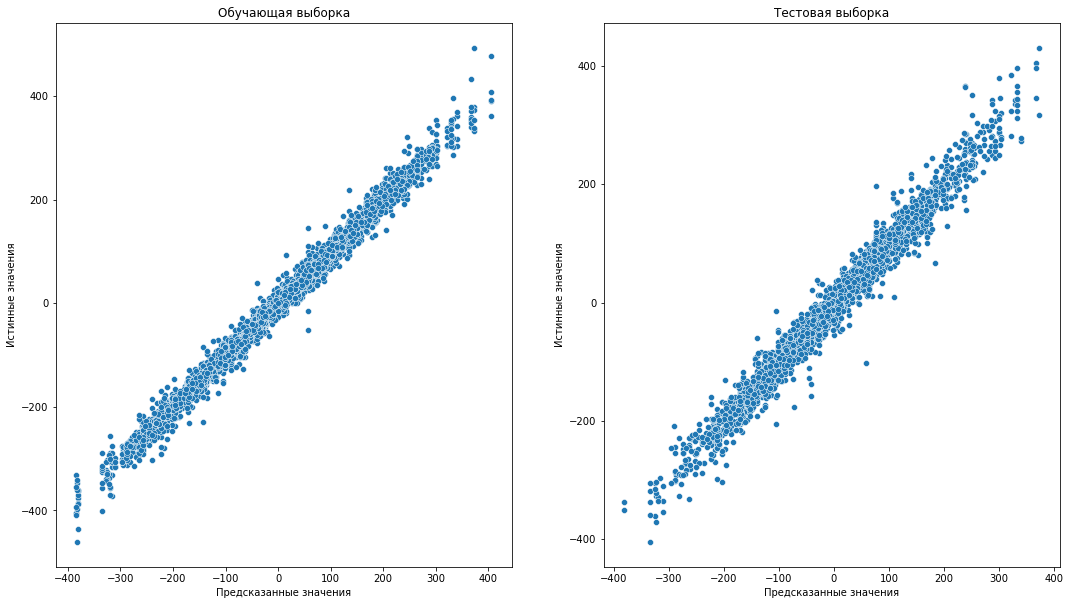

In [37]:
evaluate(y_train_true, y_train_pred, y_test_true, y_test_pred)